<a href="https://colab.research.google.com/github/jakobatgithub/unreverb/blob/main/PreprocessAudioData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

useful links:

https://towardsdatascience.com/building-a-reverb-detection-system-using-machine-learning-cba02a1710bf

https://www.openair.hosted.york.ac.uk/

https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html

https://www.gearnews.com/accentize-deroom-remove-reverb/#:~:text=Accentize%20DeRoom%20uses%20AI%20to%20remove%20reverb%20from%20your%20recordings,-11%20Mar%202020&text=Accentize%20has%20released%20DeRoom.,post%20production%20and%20podcasting%20applications

https://librosa.org/doc/main/generated/librosa.feature.inverse.mel_to_audio.html

https://towardsdatascience.com/neural-networks-for-real-time-audio-wavenet-2b5cdf791c4f


In [ ]:
#@title Imports
# When running this tutorial in Google Colab, install the required packages
# with the following.
!pip install torchaudio librosa boto3 tensorflow_io

import torch
import torchaudio
import torchaudio.functional as F
import tensorflow as tf
from tensorflow.keras import layers
import torchaudio.transforms as T
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import pandas as pd

print(torch.__version__)
print(torchaudio.__version__)

  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
1.10.0+cu111
0.10.0+cu111


In [ ]:
#@title Prepare data and utility functions I. {display-mode: "form"}
#@markdown
#@markdown Stolen from 
#@markdown https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html#simulating-room-reverbration

#-------------------------------------------------------------------------------
# Preparation of data and helper functions.
#-------------------------------------------------------------------------------
import io
import os
import math
import tarfile
import multiprocessing

import scipy
import librosa
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import requests
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import time
from IPython.display import Audio, display

[width, height] = matplotlib.rcParams['figure.figsize']
if width < 10:
  matplotlib.rcParams['figure.figsize'] = [width * 2.5, height]

_SAMPLE_DIR = "_sample_data"
SAMPLE_WAV_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.wav"
SAMPLE_WAV_PATH = os.path.join(_SAMPLE_DIR, "steam.wav")

SAMPLE_WAV_SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
SAMPLE_WAV_SPEECH_PATH = os.path.join(_SAMPLE_DIR, "speech.wav")

SAMPLE_RIR_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/room-response/rm1/impulse/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo.wav"
SAMPLE_RIR_PATH = os.path.join(_SAMPLE_DIR, "rir.wav")

SAMPLE_NOISE_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/distractors/rm1/babb/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo.wav"
SAMPLE_NOISE_PATH = os.path.join(_SAMPLE_DIR, "bg.wav")

SAMPLE_MP3_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.mp3"
SAMPLE_MP3_PATH = os.path.join(_SAMPLE_DIR, "steam.mp3")

SAMPLE_GSM_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.gsm"
SAMPLE_GSM_PATH = os.path.join(_SAMPLE_DIR, "steam.gsm")

SAMPLE_TAR_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit.tar.gz"
SAMPLE_TAR_PATH = os.path.join(_SAMPLE_DIR, "sample.tar.gz")
SAMPLE_TAR_ITEM = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"

S3_BUCKET = "pytorch-tutorial-assets"
S3_KEY = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"



In [ ]:
#@title Prepare data and utility functions II.  {display-mode: "form"}
#@markdown
#@markdown Stolen from 
#@markdown https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html#simulating-room-reverbration
#@markdown and slightly extended (see my_get_sample and my_get_ir_sample)

YESNO_DATASET_PATH = os.path.join(_SAMPLE_DIR, "yes_no")
os.makedirs(YESNO_DATASET_PATH, exist_ok=True)
os.makedirs(_SAMPLE_DIR, exist_ok=True)

def _fetch_data():
  uri = [
    (SAMPLE_WAV_URL, SAMPLE_WAV_PATH),
    (SAMPLE_WAV_SPEECH_URL, SAMPLE_WAV_SPEECH_PATH),
    (SAMPLE_RIR_URL, SAMPLE_RIR_PATH),
    (SAMPLE_NOISE_URL, SAMPLE_NOISE_PATH),
    (SAMPLE_MP3_URL, SAMPLE_MP3_PATH),
    (SAMPLE_GSM_URL, SAMPLE_GSM_PATH),
    (SAMPLE_TAR_URL, SAMPLE_TAR_PATH),
  ]
  for url, path in uri:
    with open(path, 'wb') as file_:
      file_.write(requests.get(url).content)

_fetch_data()

def _download_yesno():
  if os.path.exists(os.path.join(YESNO_DATASET_PATH, "waves_yesno.tar.gz")):
    return
  torchaudio.datasets.YESNO(root=YESNO_DATASET_PATH, download=True)

YESNO_DOWNLOAD_PROCESS = multiprocessing.Process(target=_download_yesno)
YESNO_DOWNLOAD_PROCESS.start()

def _get_sample(path, resample=None):
  effects = [
    ["remix", "1"]
  ]
  if resample:
    effects.extend([
      ["lowpass", f"{resample // 2}"],
      ["rate", f'{resample}'],
    ])
  return torchaudio.sox_effects.apply_effects_file(path, effects=effects)

def get_speech_sample(*, resample=None):
  return _get_sample(SAMPLE_WAV_SPEECH_PATH, resample=resample)

def get_sample(*, resample=None):
  return _get_sample(SAMPLE_WAV_PATH, resample=resample)

def my_get_sample(audiopath, resample=None):
  return _get_sample(audiopath, resample=resample)

def get_rir_sample(*, resample=None, processed=False):
  ir_raw, sample_rate = _get_sample(SAMPLE_RIR_PATH, resample=resample)
  if not processed:
    return ir_raw, sample_rate
  rir = ir_raw[:, int(sample_rate*1.01):int(sample_rate*1.3)]
  rir = rir / torch.norm(rir, p=2)
  rir = torch.flip(rir, [1])
  return rir, sample_rate

def my_get_ir_sample(irpath, resample=None, processed=False):
  ir_raw, sample_rate = _get_sample(irpath, resample=resample)
  if not processed:
    return ir_raw, sample_rate
  ir = ir_raw[:, int(sample_rate*1.01):int(sample_rate*1.3)]
  ir = ir / torch.norm(ir, p=2)
  ir = torch.flip(ir, [1])
  return ir, sample_rate

def get_noise_sample(*, resample=None):
  return _get_sample(SAMPLE_NOISE_PATH, resample=resample)

def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

def inspect_file(path):
  print("-" * 10)
  print("Source:", path)
  print("-" * 10)
  print(f" - File size: {os.path.getsize(path)} bytes")
  print(f" - {torchaudio.info(path)}")

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def plot_mel_fbank(fbank, title=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Filter bank')
  axs.imshow(fbank, aspect='auto')
  axs.set_ylabel('frequency bin')
  axs.set_xlabel('mel bin')
  plt.show(block=False)

def get_spectrogram(
    n_fft = 400,
    win_len = None,
    hop_len = None,
    power = 2.0,
):
  waveform, _ = get_speech_sample()
  spectrogram = T.Spectrogram(
      n_fft=n_fft,
      win_length=win_len,
      hop_length=hop_len,
      center=True,
      pad_mode="reflect",
      power=power,
  )
  return spectrogram(waveform)

def plot_pitch(waveform, sample_rate, pitch):
  figure, axis = plt.subplots(1, 1)
  axis.set_title("Pitch Feature")
  axis.grid(True)

  end_time = waveform.shape[1] / sample_rate
  time_axis = torch.linspace(0, end_time,  waveform.shape[1])
  axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

  axis2 = axis.twinx()
  time_axis = torch.linspace(0, end_time, pitch.shape[1])
  ln2 = axis2.plot(
      time_axis, pitch[0], linewidth=2, label='Pitch', color='green')

  axis2.legend(loc=0)
  plt.show(block=False)

def plot_kaldi_pitch(waveform, sample_rate, pitch, nfcc):
  figure, axis = plt.subplots(1, 1)
  axis.set_title("Kaldi Pitch Feature")
  axis.grid(True)

  end_time = waveform.shape[1] / sample_rate
  time_axis = torch.linspace(0, end_time,  waveform.shape[1])
  axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

  time_axis = torch.linspace(0, end_time, pitch.shape[1])
  ln1 = axis.plot(time_axis, pitch[0], linewidth=2, label='Pitch', color='green')
  axis.set_ylim((-1.3, 1.3))

  axis2 = axis.twinx()
  time_axis = torch.linspace(0, end_time, nfcc.shape[1])
  ln2 = axis2.plot(
      time_axis, nfcc[0], linewidth=2, label='NFCC', color='blue', linestyle='--')

  lns = ln1 + ln2
  labels = [l.get_label() for l in lns]
  axis.legend(lns, labels, loc=0)
  plt.show(block=False)

DEFAULT_OFFSET = 201
SWEEP_MAX_SAMPLE_RATE = 48000
DEFAULT_LOWPASS_FILTER_WIDTH = 6
DEFAULT_ROLLOFF = 0.99
DEFAULT_RESAMPLING_METHOD = 'sinc_interpolation'

def _get_log_freq(sample_rate, max_sweep_rate, offset):
  """Get freqs evenly spaced out in log-scale, between [0, max_sweep_rate // 2]

  offset is used to avoid negative infinity `log(offset + x)`.

  """
  half = sample_rate // 2
  start, stop = math.log(offset), math.log(offset + max_sweep_rate // 2)
  return torch.exp(torch.linspace(start, stop, sample_rate, dtype=torch.double)) - offset

def _get_inverse_log_freq(freq, sample_rate, offset):
  """Find the time where the given frequency is given by _get_log_freq"""
  half = sample_rate // 2
  return sample_rate * (math.log(1 + freq / offset) / math.log(1 + half / offset))

def _get_freq_ticks(sample_rate, offset, f_max):
  # Given the original sample rate used for generating the sweep,
  # find the x-axis value where the log-scale major frequency values fall in
  time, freq = [], []
  for exp in range(2, 5):
    for v in range(1, 10):
      f = v * 10 ** exp
      if f < sample_rate // 2:
        t = _get_inverse_log_freq(f, sample_rate, offset) / sample_rate
        time.append(t)
        freq.append(f)
  t_max = _get_inverse_log_freq(f_max, sample_rate, offset) / sample_rate
  time.append(t_max)
  freq.append(f_max)
  return time, freq

def plot_sweep(waveform, sample_rate, title, max_sweep_rate=SWEEP_MAX_SAMPLE_RATE, offset=DEFAULT_OFFSET):
  x_ticks = [100, 500, 1000, 5000, 10000, 20000, max_sweep_rate // 2]
  y_ticks = [1000, 5000, 10000, 20000, sample_rate//2]

  time, freq = _get_freq_ticks(max_sweep_rate, offset, sample_rate // 2)
  freq_x = [f if f in x_ticks and f <= max_sweep_rate // 2 else None for f in freq]
  freq_y = [f for f in freq if f >= 1000 and f in y_ticks and f <= sample_rate // 2]

  figure, axis = plt.subplots(1, 1)
  axis.specgram(waveform[0].numpy(), Fs=sample_rate)
  plt.xticks(time, freq_x)
  plt.yticks(freq_y, freq_y)
  axis.set_xlabel('Original Signal Frequency (Hz, log scale)')
  axis.set_ylabel('Waveform Frequency (Hz)')
  axis.xaxis.grid(True, alpha=0.67)
  axis.yaxis.grid(True, alpha=0.67)
  figure.suptitle(f'{title} (sample rate: {sample_rate} Hz)')
  plt.show(block=True)

def get_sine_sweep(sample_rate, offset=DEFAULT_OFFSET):
    max_sweep_rate = sample_rate
    freq = _get_log_freq(sample_rate, max_sweep_rate, offset)
    delta = 2 * math.pi * freq / sample_rate
    cummulative = torch.cumsum(delta, dim=0)
    signal = torch.sin(cummulative).unsqueeze(dim=0)
    return signal

def benchmark_resample(
    method,
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=DEFAULT_LOWPASS_FILTER_WIDTH,
    rolloff=DEFAULT_ROLLOFF,
    resampling_method=DEFAULT_RESAMPLING_METHOD,
    beta=None,
    librosa_type=None,
    iters=5
):
  if method == "functional":
    begin = time.time()
    for _ in range(iters):
      F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=lowpass_filter_width,
                 rolloff=rolloff, resampling_method=resampling_method)
    elapsed = time.time() - begin
    return elapsed / iters
  elif method == "transforms":
    resampler = T.Resample(sample_rate, resample_rate, lowpass_filter_width=lowpass_filter_width,
                           rolloff=rolloff, resampling_method=resampling_method, dtype=waveform.dtype)
    begin = time.time()
    for _ in range(iters):
      resampler(waveform)
    elapsed = time.time() - begin
    return elapsed / iters
  elif method == "librosa":
    waveform_np = waveform.squeeze().numpy()
    begin = time.time()
    for _ in range(iters):
      librosa.resample(waveform_np, sample_rate, resample_rate, res_type=librosa_type)
    elapsed = time.time() - begin
    return elapsed / iters

## Load and preprocess audio data without reverb and impulse response functions and generate audio with reverb.

In [ ]:
!ls "/content/drive/My Drive/dsr_project/data/"

alcuin-college-university-york			   but-czas_v1.0
alcuin-college-university-york.zip		   HarvardWordList
Anechoic					   r1-nuclear-reactor-hall
arthur-sykes-rymer-auditorium-university-york	   trollers-gill
arthur-sykes-rymer-auditorium-university-york.zip  trollers-gill.zip


In [ ]:
os.walk(mypath)

<generator object walk at 0x7f2e3aa2e750>

In [ ]:
from os import walk

mypath = "/content/drive/My Drive/dsr_project/data/but-czas_v1.0/wavs/F-22-02"
f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break

print(dirnames)
print(filenames)
print(mypath + filenames[0])

[]
['F-22-02-023.wav', 'F-22-02-010.wav', 'F-22-02-019.wav', 'F-22-02-005.wav', 'F-22-02-028.wav', 'F-22-02-013.wav', 'F-22-02-022.wav', 'F-22-02-003.wav', 'F-22-02-011.wav', 'F-22-02-020.wav', 'F-22-02-004.wav', 'F-22-02-032.wav', 'F-22-02-014.wav', 'F-22-02-021.wav', 'F-22-02-017.wav', 'F-22-02-030.wav', 'F-22-02-007.wav', 'F-22-02-018.wav', 'F-22-02-006.wav', 'F-22-02-027.wav', 'F-22-02-025.wav', 'F-22-02-024.wav']
/content/drive/My Drive/dsr_project/data/but-czas_v1.0/wavs/F-22-02F-22-02-023.wav


In [ ]:
# this is done here:
#   we load the audio data without reverb - the input
#   we load the impulse response (IR) functions
#   we generate the audio data with reverb by convolving all impulse response functions with all audio data without reverb
#   we transform all data to tensorflow datasets
#   one can solve two different tasks:
#     classification: which impulse response function is used
#     regression: remove the reverb from the input
#   correspondingly, we can generate two different datasets here:
#     one with the labels (consequtive numbers of the IRs) as the targets for classification
#     one with the audios without reverb as the targets (commented out)

# sampling rate for resampling
sample_rate = 8000

# all audio input should have the same length
# we split all audio data into chunks of length n
# n = 2*sample_rate corresponds to 2 seconds
# correspondingly, all audio data without reverb must be at least 2 seconds long
n = 2*sample_rate

# paths for audio without reverb
audiopaths = ["/content/drive/My Drive/dsr_project/data/HarvardWordList/SIHarvardWordListsFemale.wav",
              "/content/drive/My Drive/dsr_project/data/HarvardWordList/SIHarvardWordListsMale.wav"]

# paths to IR functions
irpaths = ["/content/drive/My Drive/dsr_project/data/r1-nuclear-reactor-hall/mono/r1_omni.wav", 
           "/content/drive/My Drive/dsr_project/data/arthur-sykes-rymer-auditorium-university-york/b-format/s1r2.wav",
           "/content/drive/My Drive/dsr_project/data/trollers-gill/b-format/dales_site1_1way_bformat.wav"]

# function to convolve IRs with audio
def my_convolve(ir, audio):
  audio_ = torch.nn.functional.pad(audio, (ir.shape[1]-1, 0))
  reverb_audio = torch.nn.functional.conv1d(audio_[None, ...], ir[None, ...])[0]
  return reverb_audio

# we number the IRs consecutively
unique_labels = [i for i in range(len(irpaths))]

# placeholder lists
irs = []
audios = []
reverb_audios = []
audio_chunks = []
reverb_audio_chunks = []
audio_chunks_2D = []
all_labels = []
labeled_reverb_audio_chunks = []

# loop over all audiofiles without reverb
for audiopath in audiopaths:
  # load audio without reverb 
  audio, _ = my_get_sample(audiopath, resample=sample_rate)
  print(f"audio.shape[1]: {audio.shape[1]}")

  # convert audio without reverb to numpy array
  #numpy_audio = audio.numpy()

  # collect alls audio without reverb in a list
  audios.append(audio)

  # split audio without reverb into chunks of length n
  audio_chunks_1D = []
  for j in range(0, audio.shape[1] - n, n):
    # a single audio chunk without reverb of length n
    audio_chunk = audio[:,j:j + n]
    
    # collect audio chunks without reverb in a list
    audio_chunks_1D.append(audio_chunk.numpy())
  
  # collect audio chunks without reverb in a 2D list
  audio_chunks_2D.append(audio_chunks_1D)


# we convolve all audios with all IRs
# counter for irpaths
iridx = 0
for irpath in irpaths:
  # load IR functions
  ir_raw, _ = my_get_ir_sample(irpath, resample=sample_rate)
  
  # shorten all IR functions to the same length
  ir = ir_raw[:, 0:int(sample_rate*1.5)]
  
  # renormalize IRs
  ir = ir / torch.norm(ir, p=2)
  
  # time reverse IRs
  ir = torch.flip(ir, [1])
  
  # collect IRs in a list
  irs.append(ir)
  
  # plot IRs
  #plot_waveform(ir, sample_rate, title="Room Impulse Response", ylim=None)
  
  # loop over all audios without reverb
  # counter for audios
  audioidx = 0
  for audio in audios:
    
    # convole audio without reverb with IRs to obtain audio with reverb
    reverb_audio = my_convolve(ir, audio)
    print(f"reverb_audio.shape[1]: {reverb_audio.shape[1]}")
    
    # collect audios with reverb in a list
    reverb_audios.append(reverb_audio)

    # counter for chunks
    chunkidx = 0
    # split audio with reverb into chunks of length n
    for j in range(0, reverb_audio.shape[1] - n, n):

      # a single audio chunk with reverb of length n
      reverb_audio_chunk = reverb_audio[:,j:j + n]
      
      # collect audio chunks with reverb in a list
      reverb_audio_chunks.append(reverb_audio_chunk.numpy())

      # collect audio chunks without reverb in a list
      audio_chunks.append(audio_chunks_2D[audioidx][chunkidx])
      
      # collect corresponding labels in a list
      all_labels.append(unique_labels[iridx])
      
      # collect tuples audio chunks with reverb and labels in a list
      labeled_reverb_audio_chunk = (reverb_audio_chunk.numpy(), unique_labels[iridx])
      labeled_reverb_audio_chunks.append(labeled_reverb_audio_chunk)
      chunkidx = chunkidx +1
    
    # increase counter for audios
    audioidx = audioidx +1
  
  # increase counter for irpaths
  iridx = iridx + 1

# convert list to numpy arrays
features = np.array(reverb_audio_chunks)
targets = np.array(audio_chunks)
labels = np.array(all_labels)
print(f"features.shape: {features.shape}")
print(f"targets.shape: {targets.shape}")
print(f"labels.shape: {labels.shape}")

# convert numpy arrays to tensorflow datasets
dataset = tf.data.Dataset.from_tensor_slices((features, labels))
#dataset = tf.data.Dataset.from_tensor_slices((features, targets))

# split dataset in train and validate
train_fraction = 0.8
split_idx = int(train_fraction*len(features))
train_dataset = tf.data.Dataset.from_tensor_slices((features[:split_idx], labels[:split_idx]))
validate_dataset = tf.data.Dataset.from_tensor_slices((features[split_idx + 1:], labels[split_idx + 1:]))
#train_dataset = tf.data.Dataset.from_tensor_slices((features[:split_idx], targets[:split_idx]))
#validate_dataset = tf.data.Dataset.from_tensor_slices((features[split_idx + 1:], targets[split_idx + 1:]))

audio.shape[1]: 2273067
reverb_audio.shape[1]: 2273067
reverb_audio.shape[1]: 2273067
reverb_audio.shape[1]: 2273067
features.shape: (426, 1, 16000)
targets.shape: (426, 1, 16000)
labels.shape: (426,)


## Simple neural network to check if the dataset has the right shape.

In [ ]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validate_dataset = validate_dataset.batch(BATCH_SIZE)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1024, input_shape=(1,16000), activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.summary()

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validate_dataset
)

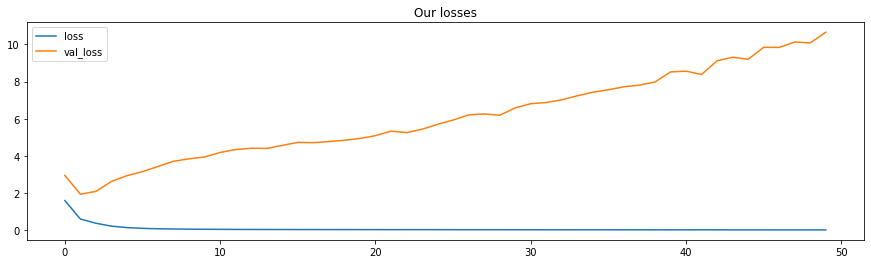

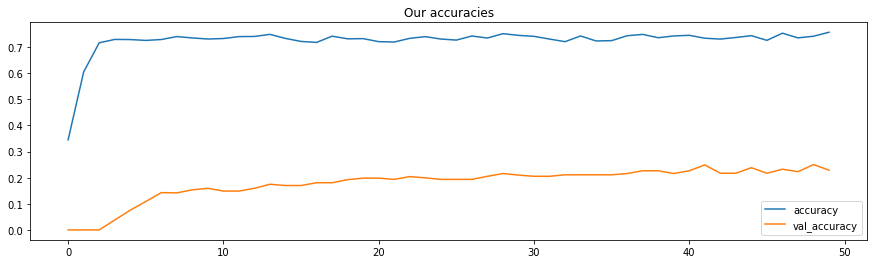

In [ ]:
def render_history(history):
    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.title("Our losses")
    plt.show()
    plt.close()

    plt.plot(history["accuracy"], label="accuracy")
    plt.plot(history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.title("Our accuracies")
    plt.show()
    plt.close()

render_history(history.history)

In [ ]:
!wget -P /content/drive/My\ Drive/dsr_project/data https://webfiles.york.ac.uk/OPENAIR/IRs/trollers-gill/trollers-gill.zip
!unzip /content/drive/My\ Drive/dsr_project/data/trollers-gill.zip -d /content/drive/My\ Drive/dsr_project/data

In [ ]:
!ls -alh /content/drive/My\ Drive/dsr_project/data/trollers-gill/b-format/dales_site1_1way_bformat.wav

-rw------- 1 root root 5.5M Aug 17  2013 '/content/drive/My Drive/dsr_project/data/trollers-gill/b-format/dales_site1_1way_bformat.wav'
